In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Tensorflow imports

# for building model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Flatten, GlobalMaxPooling1D, Dense, Dropout
from keras.initializers import Constant

# for Padding
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for Tokenization 
from tensorflow.keras.preprocessing.text import Tokenizer

# NLTK imports
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# For visualization
import matplotlib.pyplot as plt
# import seaborn as sns

# For regular expressions
import re

# For data preprocessing
from string import punctuation, digits

# loading progress
import tqdm

In [2]:
# Read in data
train_df = pd.read_csv('dataset/Corona_NLP_train.csv', encoding="Latin-1")
test_df = pd.read_csv('dataset/Corona_NLP_test.csv', encoding="Latin-1")

print(f"train dataset shape >> {train_df.shape}")
print(f"test dataset shape >> {test_df.shape}")

train dataset shape >> (41157, 6)
test dataset shape >> (3798, 6)


In [3]:
# Creat new dataset (which will consist from 2 columns: label, data)

def data_label_split(dataset):
    data = dataset['OriginalTweet']
    label = dataset['Sentiment']
    return data,label

train_data,train_label = data_label_split(train_df)
test_data,test_label = data_label_split(test_df)

train = pd.DataFrame({
    'label':train_label,
    'data':train_data
})

test = pd.DataFrame({
    'label':test_label,
    'data':test_data
})

# Define function which will make new labels

def reassign_label(x):
    if x == "Extremely Positive" or x == "Positive":
        return 1
    elif x =="Extremely Negative" or x =="Negative":
        return -1
    elif x =="Neutral":
        return 0

train.label = train.label.apply(lambda x:reassign_label(x))
test.label = test.label.apply(lambda x:reassign_label(x))

## Data preprocessing

In [4]:
def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s.lower()

def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', '', sentence) # remove URL adresses
    sentence = re.sub(r"\@(\w+)", '', sentence) # remove usernames
    sentence = re.sub(r"\#(\w+)", '', sentence) # remove hashtags
    sentence = re.sub(r"\$(\w+)", '', sentence) # remove cashtags
    sentence = sentence.replace("-",' ')
    tokens = sentence.split()
    tokens = [remove_punctuation(w) for w in tokens] # remove punctuations
    stop_words = set(stopwords.words('english')) # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]
    remove_digits = str.maketrans('', '', digits)
    tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
    tokens = ' '.join(tokens)
    return tokens

def process_text(text):
  text = str(text) #Convert string to str
  #Lowers the string
  text = text.lower()
  #Removes the full url
  url_remove = re.compile(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
  text = re.sub(url_remove,' ',text)
  #Removes the punctuation
  text = ''.join([string for string in text if string not in punctuation and not string.isdigit()])
  #Removes any more special characters
  special_character = re.compile(r'[^a-zA-Z]')
  text = re.sub(special_character,' ', text)
  text = text.strip() #Strip white spaces
  text = text.split(' ')
  text = ' '.join([string for string in text if string not in stopwords.words('english')])#Removing all stop words
  return text

In [5]:
# Clean sentences in train and test data
train.data = train.data.apply(lambda sentence:clean_sentence(sentence))
test.data = test.data.apply(lambda sentence:clean_sentence(sentence))

#train.data = train.data.apply(process_text)
#test.data = test.data.apply(process_text)

In [6]:
# Splitting data to train and test

# Train data
train_data = train.data
train_label = train.label

# Test data
test_data = test.data
test_label = test.label

In [7]:
# Convert categorical variable (in our case: -1, 0, 1) into dummy/indicator variables. Such as -1 to 1 0 0 
train_label = pd.get_dummies(train_label)
test_label = pd.get_dummies(test_label)

## Lemmatization

In [8]:
lemmatizer = WordNetLemmatizer()

# Function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function below is necessery to find lemma of each word
def lemmatize_sentence(de_punct_sent):
    # Tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(de_punct_sent))
    # Tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [9]:
# Lemmatization of train and test data
train_lem = [lemmatize_sentence(i) for i in train_data]
test_lem = [lemmatize_sentence(i) for i in test_data]

## Tokenization

In [10]:
samples_1 = train_lem
samples_2 = test_lem

tokenizer = Tokenizer()
tokenizer.fit_on_texts(samples_1) # Create an index of all words from training data

# Convert strings to integer index lists

# After that, we pass the ready-made (from the line above) indexes for all words from train
train_data = tokenizer.texts_to_sequences(samples_1)
# And for test. So, we should get the same word indexes in the two texts
test_data = tokenizer.texts_to_sequences(samples_2)

word_index = tokenizer.word_index # Find out the calculated index of words
print('Found %s unique tokens.' % len(word_index))

Found 32445 unique tokens.


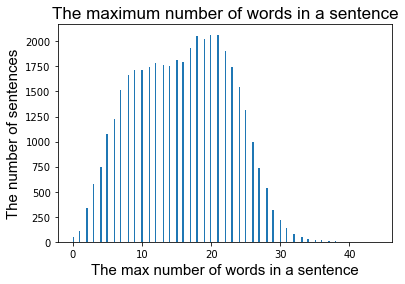

In [11]:
# Now we want to find out what is the maximum number of words in a sentence. 
# After that, we will fill in the sentences with the missing number of words.

lens =  [len(s) for s in train_data]

plt.title('The maximum number of words in a sentence', fontdict={'fontname': 'Arial', 'fontsize': 17})
plt.xlabel('The max number of words in a sentence', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('The number of sentences', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.hist(lens,bins=200)
plt.show()

In [12]:
maxlen = 40 # maximal length of sentences

# Convert lists of integers to a two-dimensional tensor 
# with integers and with a shape (samples, max. length)

train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen, padding='post', truncating='post') 
test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen, padding='post', truncating='post')

In [46]:
import tqdm
import requests
import zipfile
import os
URLs = ["http://nlp.stanford.edu/data/glove.42B.300d.zip", "https://nlp.stanford.edu/data/glove.6B.zip"]
GLOVES = ['glove.6B.100d.txt', 'glove.42B.300d.txt']

def fetch_data(url, target_file=os.path.join('embeddings','glove.zip'), delete_zip=True):
    current_directory = os.getcwd()
    if not os.path.isdir(os.path.join(current_directory, "embeddings")):
        os.mkdir(os.path.join(current_directory, "embeddings"))
    
    if os.path.isfile(target_file):
        print("datasets already downloded :) ")
    else:
        response = requests.get(url, stream=True)
        #read chunk by chunk
        handle = open(target_file, "wb")
        for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
            if chunk:  
                handle.write(chunk)
        handle.close()  
        print("  Download completed ;) :") 
    
    #extract zip_file
    with zipfile.ZipFile(target_file, 'r') as zip_ref:
        for zipinfo in zip_ref.infolist():
            print("1. Extracting {} file".format(target_file))
            if (os.path.isfile(os.path.join('embeddings', zipinfo.filename))):
                continue
            zip_ref.extract(zipinfo, "embeddings")
    
    if delete_zip:
        print("2. Deleting {} file".format(target_file))
        os.remove(path=target_file)

## ------------------------------------------------------------------------------- ##        
## if word embeddings need to be downloaded just uncomment all the following lines ##
## ------------------------------------------------------------------------------- ##        

# fetch_data("https://nlp.stanford.edu/data/glove.6B.zip")
# fetch_data("http://nlp.stanford.edu/data/glove.42B.300d.zip")
# fetch_data("https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip")
# fetch_data("https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip")
# fetch_data("https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip")
# fetch_data("https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip")
# fetch_data("https://nlp.stanford.edu/data/glove.840B.300d.zip")
# fetch_data("https://nlp.stanford.edu/data/glove.twitter.27B.zip")

# link to download gogle word embeddings - https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g

4251502it [06:52, 10313.25it/s]


  Download completed ;) :
1. Extracting embeddings\glove.zip file
2. Deleting embeddings\glove.zip file


2969548it [04:47, 10335.06it/s]


  Download completed ;) :
1. Extracting embeddings\glove.zip file
1. Extracting embeddings\glove.zip file
1. Extracting embeddings\glove.zip file
1. Extracting embeddings\glove.zip file
2. Deleting embeddings\glove.zip file


## Code for various word embeddings

In [13]:
import io

def load_ff_vectors(fname):
    # fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    # n, d = map(int, fin.readline().split())
    # data = {}
    # for line in fin:
    #     tokens = line.rstrip().split(' ')
    #     data[tokens[0]] = map(float, tokens[1:])

    embedding_dict = {}
    with open(fname, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                try:
                    vector = np.asarray(values[1:], 'float32')
                    embedding_dict[word] = vector
                except:
                    print("An incorrect vector was found and skipped")

    return embedding_dict



def construct_embedding_matrix(glove_file, emb_length, word_index=word_index):
    embedding_dict = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                try:
                    vector = np.asarray(values[1:], 'float32')
                    embedding_dict[word] = vector
                except:
                    print("An incorrect vector was found and skipped")
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, emb_length))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:emb_length]
    return embedding_matrix

def construct_embedding_matrix_from_ff(ffname, emb_length, word_index=word_index):

    embedding_dict = load_ff_vectors(ffname)

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, emb_length))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:emb_length]
    return embedding_matrix

# embedding_matrix =  construct_embedding_matrix(glove_file, word_index)

## Building Classification Model

In [14]:
def create_model(embedding_dim, embedding_matrix, vocab_inp_size=len(word_index)+1, hidden_size=256):
        model = Sequential() 

        # The Embedding layer is necessery in order to convert words (in out case from integers) to vectors
        model.add(Embedding(input_dim = vocab_inp_size, output_dim = embedding_dim, input_length = maxlen, embeddings_initializer=Constant(embedding_matrix)))
        # model.add(Embedding(input_dim = vocab_inp_size, output_dim = embedding_dim, input_length = maxlen))

        # Apply Dropout to use recurrent decimation to combat overfitting 
        model.add(LSTM(hidden_size, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)) 

        # Use Flatten() or GlobalMaxPooling1D() to convert 3D output to 2D.
        # It allows you to add one or more Dense layers to your model 
        model.add(Flatten()) # or model.add(GlobalMaxPooling1D())

        #model.add(Dense(64, activation='relu'))#as experiment we tried to add one additional layer,but it is not give as higher accuracy
        #model.add(Dropout(0.4))

        model.add(Dense(3, activation='softmax'))#activation function for classification

        model.summary()

        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy']) 

        return model

        # access the embedding layer through the constructed model 
        # first `0` refers to the position of embedding layer in the `model`
        embeddings = model.layers[0].get_weights()[0]

        # `embeddings` has a shape of (num_vocab, embedding_dim) 

        # `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
        words_embeddings = {w:embeddings[idx] for w, idx in word_index.items()}

def train_model(name, embedding_dim, embedding_matrix, vocab_inp_size=len(word_index)+1, hidden_size=256):
        model = create_model(embedding_dim, embedding_matrix, vocab_inp_size, hidden_size)

        from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

        early_stopping =EarlyStopping(monitor='val_loss', patience=3)
        bst_model_path = name + '.h5'
        model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True)

        model.fit(train_data, train_label, \
                epochs=20, batch_size=128, validation_split=0.2, \
                callbacks=[early_stopping, model_checkpoint, CSVLogger(f"history_{name}.csv")])

        #model.load_weights(bst_model_path)

In [21]:
# embedding_matrix_glove_6b_50d =  construct_embedding_matrix("embeddings/glove.6B.50d.txt", 50)
# train_model("simple_lstm_glove_vectors_6B_50d", 50, embedding_matrix_glove_6b_50d)

embedding_matrix_glove_6b_100d =  construct_embedding_matrix("embeddings/glove.6B.100d.txt", 100)
train_model("simple_lstm_glove_vectors_6B_100d", 100, embedding_matrix_glove_6b_100d)

embedding_matrix_glove_6b_200d =  construct_embedding_matrix("embeddings/glove.6B.200d.txt", 200)
train_model("simple_lstm_glove_vectors_6B_200d", 200, embedding_matrix_glove_6b_200d)

embedding_matrix_glove_6b_300d =  construct_embedding_matrix("embeddings/glove.6B.300d.txt", 300)
train_model("simple_lstm_glove_vectors_6B_300d", 300, embedding_matrix_glove_6b_300d)


embedding_matrix_glove_42b_300d =  construct_embedding_matrix("embeddings/glove.42B.300d.txt", 300)
train_model("simple_lstm_glove_vectors_42B_300d", 300, embedding_matrix_glove_42b_300d)
embedding_matrix_glove_840b_300d =  construct_embedding_matrix("embeddings/glove.840B.300d.txt", 300)
train_model("simple_lstm_glove_vectors_840B_300d", 300, embedding_matrix_glove_840b_300d)

embedding_matrix_glove_27b_25d =  construct_embedding_matrix("embeddings/glove.twitter.27B.25d.txt", 25)
train_model("simple_lstm_glove_twitter_vectors_27B_25d", 25, embedding_matrix_glove_27b_25d)
embedding_matrix_glove_27b_50d =  construct_embedding_matrix("embeddings/glove.twitter.27B.50d.txt", 50)
train_model("simple_lstm_glove_twitter_vectors_27B_50d", 50, embedding_matrix_glove_27b_50d)
embedding_matrix_glove_27b_100d =  construct_embedding_matrix("embeddings/glove.twitter.27B.100d.txt", 100)
train_model("simple_lstm_glove_twitter_vectors_27B_100d", 100, embedding_matrix_glove_27b_100d)
embedding_matrix_glove_27b_200d =  construct_embedding_matrix("embeddings/glove.twitter.27B.200d.txt", 200)
train_model("simple_lstm_glove_twitter_vectors_27B_200d", 200, embedding_matrix_glove_27b_200d)

embedding_matrix_ff_600B_300d = construct_embedding_matrix_from_ff("embeddings/crawl-300d-2M.vec", 300)
train_model("simple_lstm_ff_vectors_600B_300d", 300, embedding_matrix_ff_600B_300d)

embedding_matrix_ff_subwords_600B_300d = construct_embedding_matrix_from_ff("embeddings/crawl-300d-2M-subword.vec", 300)
train_model("simple_lstm_ff_subwords_vectors_600B_300d", 300, embedding_matrix_ff_subwords_600B_300d)

embedding_matrix_ff_wiki_16B_300d = construct_embedding_matrix_from_ff("embeddings/wiki-news-300d-1M.vec", 300)
train_model("simple_lstm_ff_wiki_vectors_16B_300d", 300, embedding_matrix_ff_wiki_16B_300d)

embedding_matrix_ff_wiki_subwords_16B_300d = construct_embedding_matrix_from_ff("embeddings/wiki-news-300d-1M-subword.vec", 300)
train_model("simple_lstm_ff_wiki_subwords_vectors_16B_300d", 300, embedding_matrix_ff_wiki_subwords_16B_300d)

100%|██████████| 32445/32445 [00:00<00:00, 956836.75it/s]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 100)           3244600   
                                                                 
 lstm_2 (LSTM)               (None, 40, 256)           365568    
                                                                 
 flatten_2 (Flatten)         (None, 10240)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 30723     
                                                                 
Total params: 3,640,891
Trainable params: 3,640,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 49s 182ms/step - loss: 0.8086 - categorical_accuracy: 0.6403 - val_loss: 0.6842 - val_categorical_accuracy: 0.7071
Epoch 2

100%|██████████| 32445/32445 [00:00<00:00, 711960.83it/s]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 200)           6489200   
                                                                 
 lstm_3 (LSTM)               (None, 40, 256)           467968    
                                                                 
 flatten_3 (Flatten)         (None, 10240)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                 30723     
                                                                 
Total params: 6,987,891
Trainable params: 6,987,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 74s 282ms/step - loss: 0.7756 - categorical_accuracy: 0.6623 - val_loss: 0.6927 - val_categorical_accuracy: 0.7138
Epoch 2

100%|██████████| 32445/32445 [00:00<00:00, 591755.31it/s]


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 40, 300)           9733800   
                                                                 
 lstm_4 (LSTM)               (None, 40, 256)           570368    
                                                                 
 flatten_4 (Flatten)         (None, 10240)             0         
                                                                 
 dense_4 (Dense)             (None, 3)                 30723     
                                                                 
Total params: 10,334,891
Trainable params: 10,334,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 92s 352ms/step - loss: 0.7457 - categorical_accuracy: 0.6821 - val_loss: 0.6514 - val_categorical_accuracy: 0.7276
Epoch

100%|██████████| 32445/32445 [00:00<00:00, 677743.88it/s]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 40, 300)           9733800   
                                                                 
 lstm_5 (LSTM)               (None, 40, 256)           570368    
                                                                 
 flatten_5 (Flatten)         (None, 10240)             0         
                                                                 
 dense_5 (Dense)             (None, 3)                 30723     
                                                                 
Total params: 10,334,891
Trainable params: 10,334,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 72s 274ms/step - loss: 0.7335 - categorical_accuracy: 0.6844 - val_loss: 0.5725 - val_categorical_accuracy: 0.7732
Epoch

100%|██████████| 32445/32445 [00:00<00:00, 722414.95it/s]


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 40, 300)           9733800   
                                                                 
 lstm_6 (LSTM)               (None, 40, 256)           570368    
                                                                 
 flatten_6 (Flatten)         (None, 10240)             0         
                                                                 
 dense_6 (Dense)             (None, 3)                 30723     
                                                                 
Total params: 10,334,891
Trainable params: 10,334,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 87s 332ms/step - loss: 0.7266 - categorical_accuracy: 0.6918 - val_loss: 0.6239 - val_categorical_accuracy: 0.7556
Epoch

100%|██████████| 32445/32445 [00:00<00:00, 1160929.82it/s]


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 25)            811150    
                                                                 
 lstm_7 (LSTM)               (None, 40, 256)           288768    
                                                                 
 flatten_7 (Flatten)         (None, 10240)             0         
                                                                 
 dense_7 (Dense)             (None, 3)                 30723     
                                                                 
Total params: 1,130,641
Trainable params: 1,130,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 37s 136ms/step - loss: 0.8989 - categorical_accuracy: 0.5773 - val_loss: 0.8614 - val_categorical_accuracy: 0.6064
Epoch 2

100%|██████████| 32445/32445 [00:00<00:00, 1016653.79it/s]


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 40, 50)            1622300   
                                                                 
 lstm_8 (LSTM)               (None, 40, 256)           314368    
                                                                 
 flatten_8 (Flatten)         (None, 10240)             0         
                                                                 
 dense_8 (Dense)             (None, 3)                 30723     
                                                                 
Total params: 1,967,391
Trainable params: 1,967,391
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 44s 164ms/step - loss: 0.8436 - categorical_accuracy: 0.6172 - val_loss: 0.7100 - val_categorical_accuracy: 0.7048
Epoch 2

100%|██████████| 32445/32445 [00:00<00:00, 903673.51it/s]


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 40, 100)           3244600   
                                                                 
 lstm_9 (LSTM)               (None, 40, 256)           365568    
                                                                 
 flatten_9 (Flatten)         (None, 10240)             0         
                                                                 
 dense_9 (Dense)             (None, 3)                 30723     
                                                                 
Total params: 3,640,891
Trainable params: 3,640,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 67s 254ms/step - loss: 0.7987 - categorical_accuracy: 0.6468 - val_loss: 0.6446 - val_categorical_accuracy: 0.7348
Epoch 2

100%|██████████| 32445/32445 [00:00<00:00, 774063.27it/s]


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 40, 200)           6489200   
                                                                 
 lstm_10 (LSTM)              (None, 40, 256)           467968    
                                                                 
 flatten_10 (Flatten)        (None, 10240)             0         
                                                                 
 dense_10 (Dense)            (None, 3)                 30723     
                                                                 
Total params: 6,987,891
Trainable params: 6,987,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 75s 285ms/step - loss: 0.7626 - categorical_accuracy: 0.6675 - val_loss: 0.6185 - val_categorical_accuracy: 0.7523
Epoch 

100%|██████████| 32445/32445 [00:00<00:00, 638233.72it/s]


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 40, 300)           9733800   
                                                                 
 lstm_11 (LSTM)              (None, 40, 256)           570368    
                                                                 
 flatten_11 (Flatten)        (None, 10240)             0         
                                                                 
 dense_11 (Dense)            (None, 3)                 30723     
                                                                 
Total params: 10,334,891
Trainable params: 10,334,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 96s 365ms/step - loss: 0.7136 - categorical_accuracy: 0.6988 - val_loss: 0.5875 - val_categorical_accuracy: 0.7828
Epoc

100%|██████████| 32445/32445 [00:00<00:00, 691762.41it/s]


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 40, 300)           9733800   
                                                                 
 lstm_12 (LSTM)              (None, 40, 256)           570368    
                                                                 
 flatten_12 (Flatten)        (None, 10240)             0         
                                                                 
 dense_12 (Dense)            (None, 3)                 30723     
                                                                 
Total params: 10,334,891
Trainable params: 10,334,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 105s 403ms/step - loss: 0.6812 - categorical_accuracy: 0.7188 - val_loss: 0.5118 - val_categorical_accuracy: 0.8185
Epo

100%|██████████| 32445/32445 [00:00<00:00, 739379.05it/s]


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 40, 300)           9733800   
                                                                 
 lstm_13 (LSTM)              (None, 40, 256)           570368    
                                                                 
 flatten_13 (Flatten)        (None, 10240)             0         
                                                                 
 dense_13 (Dense)            (None, 3)                 30723     
                                                                 
Total params: 10,334,891
Trainable params: 10,334,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 103s 394ms/step - loss: 0.6918 - categorical_accuracy: 0.7087 - val_loss: 0.5218 - val_categorical_accuracy: 0.8200
Epo

100%|██████████| 32445/32445 [00:00<00:00, 756451.95it/s]


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 40, 300)           9733800   
                                                                 
 lstm_14 (LSTM)              (None, 40, 256)           570368    
                                                                 
 flatten_14 (Flatten)        (None, 10240)             0         
                                                                 
 dense_14 (Dense)            (None, 3)                 30723     
                                                                 
Total params: 10,334,891
Trainable params: 10,334,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 103s 393ms/step - loss: 0.6861 - categorical_accuracy: 0.7144 - val_loss: 0.6433 - val_categorical_accuracy: 0.7455
Epo

In [60]:
# play around with word embedding

# access the embedding layer through the constructed model 
# first `0` refers to the position of embedding layer in the `model`
embeddings = model.layers[0].get_weights()[0]

# `embeddings` has a shape of (num_vocab, embedding_dim) 

# `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
words_embeddings = {w:embeddings[idx] for w, idx in word_index.items()}

# now you can use it like this for example
print(words_embeddings['covid'])  # possible output: [0.21, 0.56, ..., 0.65, 0.10]

(10240, 3)


## Visualization of model training

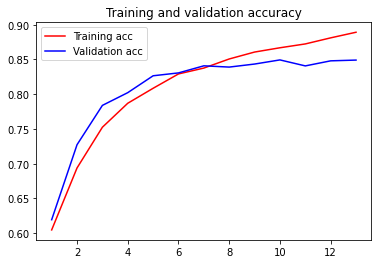

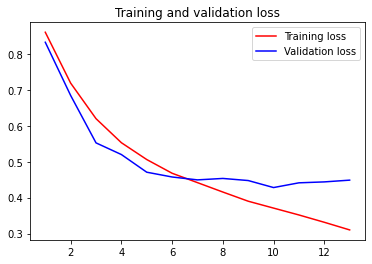

In [82]:
acc = hist.history['categorical_accuracy']
val_acc = hist.history['val_categorical_accuracy'] 
loss = hist.history['loss'] 
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model Evaluation

In [23]:
import os

directory = os.fsencode(".")
    
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.startswith("simple_lstm"):
         model = keras.models.load_model(filename)
         eval_ = model.evaluate(test_data, test_label)
         print(filename, eval_, "\n")
     

119/119 [==============================] - 7s 54ms/step - loss: 0.4927 - categorical_accuracy: 0.8394
simple_lstm_ff_subwords_vectors_600B_300d.h5 [0.4926719069480896, 0.8393891453742981]
119/119 [==============================] - 7s 56ms/step - loss: 0.4884 - categorical_accuracy: 0.8315
simple_lstm_ff_vectors_600B_300d.h5 [0.48840096592903137, 0.8314902782440186]
119/119 [==============================] - 7s 57ms/step - loss: 0.5232 - categorical_accuracy: 0.8120
simple_lstm_ff_wiki_subwords_vectors_16B_300d.h5 [0.5231635570526123, 0.8120062947273254]
119/119 [==============================] - 7s 58ms/step - loss: 0.4774 - categorical_accuracy: 0.8323
simple_lstm_ff_wiki_vectors_16B_300d.h5 [0.4773871898651123, 0.832280158996582]
119/119 [==============================] - 5s 41ms/step - loss: 0.4734 - categorical_accuracy: 0.8404
simple_lstm_glove_twitter_vectors_27B_100d.h5 [0.47339096665382385, 0.8404423594474792]
119/119 [==============================] - 5s 37ms/step - loss: 0.48

In [20]:


model = keras.models.load_model("simple_lstm_glove_vectors_6B_50d.h5")
lala = model.evaluate(test_data,test_label)
print(lala)

119/119 [==============================] - 1s 11ms/step - loss: 0.4810 - categorical_accuracy: 0.8270
[0.4809766113758087, 0.8270142078399658]


In [83]:
model.evaluate(test_data,test_label)

119/119 [==============================] - 3s 28ms/step - loss: 0.5000 - categorical_accuracy: 0.8362


[0.5000237822532654, 0.8362296223640442]

In [62]:
preds = model.predict(test_data)
print(preds)

[[9.9999988e-01 5.5431880e-08 8.3485602e-08]
 [1.9440079e-06 1.1493577e-05 9.9998653e-01]
 [3.4574812e-05 4.0242117e-05 9.9992514e-01]
 ...
 [2.5318811e-06 9.9999619e-01 1.3368275e-06]
 [9.9998915e-01 2.3572570e-06 8.4519243e-06]
 [1.4903995e-07 4.5983994e-09 9.9999988e-01]]
